In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import math
from string import ascii_uppercase

import analysis.n_learnt
import analysis.p_recall
import explo_leitner

In [3]:
fig_folder = os.path.join("fig")
os.makedirs(fig_folder, exist_ok=True)

In [4]:
def roundup(x, base=100):
    return base * math.ceil(x/base)


def rounddown(x, base=100):
    return base * math.floor(x / base)

In [5]:
def rename_teachers(data):
    dic = {
        "leitner": "Leitner",
        "forward": "Cons.\nsampling",
        "threshold": "Myopic",
    }

    for k, v in dic.items():
        data["teacher"] = data["teacher"].replace([k], v)
    return data

In [12]:
def heatmap(data, ax, fontsize_label, fontsize_colorbar):

    data["alpha"] = data["alpha"].round(7)
    data["beta"] = data["beta"].round(4)
    data_pivoted = data.pivot("alpha", "beta", "n_learnt")

    # Draw heatmap
    sns.heatmap(data=data_pivoted, cmap="viridis", ax=ax,
                cbar_kws={"orientation": "horizontal", "pad": 0.25})
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    # cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Learned via Leitner', size=fontsize_colorbar)

    alpha_unique = sorted(data["alpha"].unique())
    beta_unique = sorted(data["beta"].unique())
    grid_size = len(alpha_unique)

    ax.set_ylabel(r"$\alpha$", fontsize=fontsize_label)
    ax.set_xlabel(r"$\beta$", fontsize=fontsize_label)

    ax.set_xticks((0.5, grid_size / 2 - 0.5, grid_size - 0.5))
    ax.set_xticklabels((beta_unique[0], beta_unique[grid_size//2 -1],
                        beta_unique[-1]), rotation=0)

    ax.set_yticks((0.5, grid_size / 2 - 0.5, grid_size - 0.5))
    ax.set_yticklabels((alpha_unique[0], alpha_unique[grid_size//2 - 1],
                        alpha_unique[-1]), rotation=0)

    np.random.seed(123)
    n_agent = 100

    n_learnt = data["n_learnt"].values
    alpha = data["alpha"].values
    beta = data["beta"].values

    smart_enough = np.flatnonzero(n_learnt > 0)
    slc = np.random.choice(smart_enough, size=n_agent, replace=False)
    alpha_v = alpha[slc]
    beta_v = beta[slc]
    alpha_coord = np.array([alpha_unique.index(v)
                            for v in alpha_v], dtype=float) + 0.5
    beta_coord = np.array([beta_unique.index(v)
                           for v in beta_v], dtype=float) + 0.5
    ax.scatter(beta_coord, alpha_coord, color='red', s=10)

    # Invert y-axis
    ax.invert_yaxis()

    # Make it look square
    ax.set_aspect(1)


def boxplot_n_learnt(data, ax,
                     ylim,
                     x_label="Teacher",
                     y_label="Learned", dot_size=3, dot_alpha=0.7,
                     fontsize_label=13):

    data = rename_teachers(data)
    data = data.rename(columns={
        "n_learnt": y_label,
        "teacher": x_label
    })

    order = ["Leitner", "Myopic", "Cons.\nsampling"]
    colors = ["C0", "C1", "C2"]

    sns.boxplot(x=x_label, y=y_label, data=data, ax=ax,
                palette=colors, order=order,
                showfliers=False)
    sns.stripplot(x=x_label, y=y_label, data=data, s=dot_size,
                  color="0.25", alpha=dot_alpha, ax=ax, order=order)
    
    ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize_label)

    ax.set_ylim(ylim[0], ylim[1])

    ax.set_xlabel("")


def boxplot_n_learnt_n_seen(data, ax,
                            x_label="Teacher",
                            y_label="Learned / seen",
                            dot_size=3, dot_alpha=0.7,
                            fontsize_label=13):

    data = rename_teachers(data)
    data = data.rename(columns={
        "teacher": x_label,
        "ratio_n_learnt_n_seen": y_label
    })

    order = ["Leitner", "Myopic", "Cons.\nsampling"]
    colors = ["C0", "C1", "C2"]

    sns.boxplot(x="Teacher", y=y_label, data=data, ax=ax,
                palette=colors, order=order,
                showfliers=False)
    sns.stripplot(x="Teacher", y=y_label, data=data,
                  color="0.25", alpha=dot_alpha, ax=ax, order=order,
                  s=dot_size)
    
    ax.set_ylabel(y_label, fontsize=fontsize_label)

    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize_label)

    ax.set_ylim(-0.025, 1.025)
    ax.set_yticks((0, 0.5, 1))

    ax.set_xlabel("")


def prediction_error(data, ax, title, color,
                     x_label="Number of teaching interactions",
#                      y_label="Prediction error\n"
#                              "(prob. of recall)",
                     fontsize_label=12):

    sns.lineplot(data=data, x="time", y="p_err_mean", ci="sd", ax=ax, color=color)
    
    ax.set_xlabel(x_label, fontsize=fontsize_label)
    # ax.set_ylabel(y_label, fontsize=fontsize_label)
    ax.set_ylabel("")
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    ax.set_title(title, fontsize=fontsize_label)

In [13]:
# Parameters figure
fontsize_title = 22
fontsize_label_heatmap = 18
fontsize_colorbar = 18
fontsize_label_boxplot = 18
fontsize_subtitle = 18
fontsize_condition = 22
fontsize_label_lineplot = 18
fontsize_letter = 22

# Figure 2

In [14]:
dataset = "n_learnt_leitner"

df_heat = explo_leitner.get_data()

df_omni = analysis.n_learnt.get_data(dataset_name=dataset,
                                     condition_name="Nspec-omni")

df_not_omni = analysis.n_learnt.get_data(dataset_name=dataset,
                                         condition_name="Nspec-Nomni")

x1 = df_omni.n_learnt
x2 = df_not_omni.n_learnt
min1, max1 = np.min(x1), np.max(x1)
min2, max2 = np.min(x2), np.max(x2)
min_v = np.min((min1, min2))
max_v = np.max((max1, max2))
ylim = (rounddown(min_v, 50)-10, roundup(max_v, 50)+10)

err_threshold = analysis.p_recall.get_data(
    dataset_name=dataset,
    condition_name="Nspec-Nomni",
    teacher_name="threshold")

err_forward = analysis.p_recall.get_data(
    dataset_name=dataset,
    condition_name="Nspec-Nomni",
    teacher_name="forward")

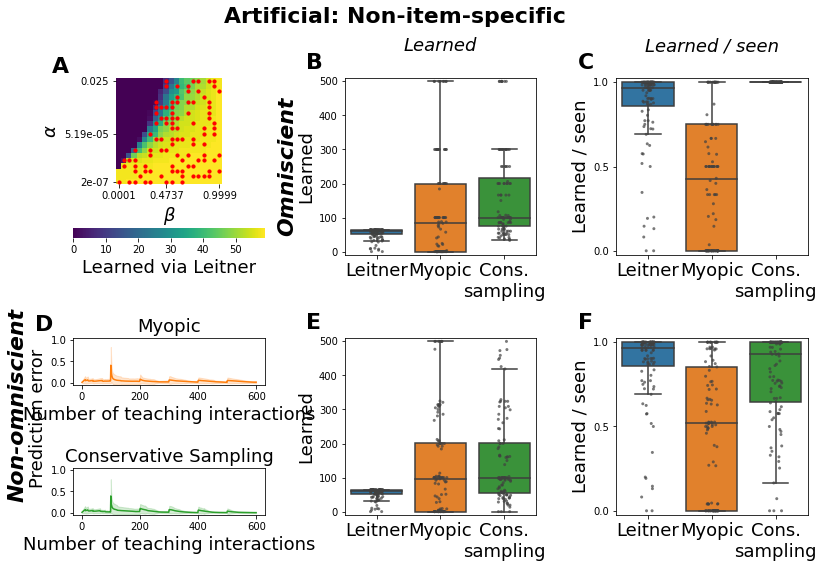

In [15]:
fig = plt.figure(figsize=(12, 8))  # (13, 8.5)
fig.suptitle("Artificial: Non-item-specific",
             fontweight="bold",
             fontsize=fontsize_title)

# Thanks to the Matplotlib creators that I love
pos = [(4, 3, (1, 4)), (4, 3, (2, 5)), (4, 3, (3, 6)),
       (4, 3, 7), (4, 3, 10), (4, 3, (8, 11)), (4, 3, (9, 12))]
axes = [fig.add_subplot(*p) for p in pos]

heatmap(data=df_heat, ax=axes[0], 
        fontsize_label=fontsize_label_heatmap, 
        fontsize_colorbar=fontsize_colorbar)

# Boxplots
boxplot_n_learnt(data=df_omni, ax=axes[1], ylim=ylim, fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt_n_seen(data=df_omni, ax=axes[2], fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt(data=df_not_omni, ax=axes[5], ylim=ylim, fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt_n_seen(data=df_not_omni, ax=axes[6], fontsize_label=fontsize_label_boxplot)

# Prediction errors
prediction_error(data=err_threshold, ax=axes[3],
                 title="Myopic",
                 color="C1",
                 fontsize_label=fontsize_label_lineplot)

prediction_error(data=err_forward, ax=axes[4],
                 title="Conservative Sampling",
                 color="C2",
                 fontsize_label=fontsize_label_lineplot)

# Add subtitles for metric
axes[1].set_title("Learned\n", fontstyle='italic', fontsize=fontsize_subtitle)
axes[2].set_title("Learned / seen\n", fontstyle='italic', fontsize=fontsize_subtitle)

# Add invisible axes
ax_off = fig.add_subplot(1, 1, 1)
ax_off.set_axis_off()

# Add y-label for prediction error plot
ax_off.text(-0.06, 0.07, "Prediction error",
            transform=ax_off.transAxes, size=fontsize_label_lineplot, rotation=90)

# Add subtitles for condition
axes[1].text(-0.3, 0.5, "Omniscient",
             horizontalalignment='center',
             verticalalignment='center',
             transform=axes[1].transAxes, size=fontsize_condition, weight='bold', 
             rotation=90, style="italic")
ax_off.text(-0.09, 0.04, "Non-omniscient", transform=ax_off.transAxes, size=fontsize_condition, weight='bold',
            rotation=90, style="italic")

# Add letters
axes[0].text(-0.6, 1.05, ascii_uppercase[0], transform=axes[0].transAxes, size=fontsize_letter, weight='bold')
axes[1].text(-0.2, 1.05, ascii_uppercase[1], transform=axes[1].transAxes, size=fontsize_letter, weight='bold')
axes[2].text(-0.2, 1.05, ascii_uppercase[2], transform=axes[2].transAxes, size=fontsize_letter, weight='bold')
axes[3].text(-0.2, 1.15, ascii_uppercase[3], transform=axes[3].transAxes, size=fontsize_letter, weight='bold')
axes[5].text(-0.2, 1.05, ascii_uppercase[4], transform=axes[5].transAxes, size=fontsize_letter, weight='bold')
axes[6].text(-0.2, 1.05, ascii_uppercase[5], transform=axes[6].transAxes, size=fontsize_letter, weight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])

plt.savefig(os.path.join(fig_folder, f"fig2.png"), dpi=300)
plt.savefig(os.path.join(fig_folder, f"fig2.pdf"))

# Figure 3

In [16]:
dataset = "n_learnt_leitner"

df_omni = analysis.n_learnt.get_data(dataset_name=dataset,
                                     condition_name="spec-omni")

df_not_omni = analysis.n_learnt.get_data(dataset_name=dataset,
                                         condition_name="spec-Nomni")

x1 = df_omni.n_learnt
x2 = df_not_omni.n_learnt
min1, max1 = np.min(x1), np.max(x1)
min2, max2 = np.min(x2), np.max(x2)
min_v = np.min((min1, min2))
max_v = np.max((max1, max2))
ylim = (rounddown(min_v, 10), roundup(max_v, 10))

err_threshold = analysis.p_recall.get_data(
    dataset_name=dataset,
    condition_name="spec-Nomni",
    teacher_name="threshold")

err_forward = analysis.p_recall.get_data(
    dataset_name=dataset,
    condition_name="spec-Nomni",
    teacher_name="forward")

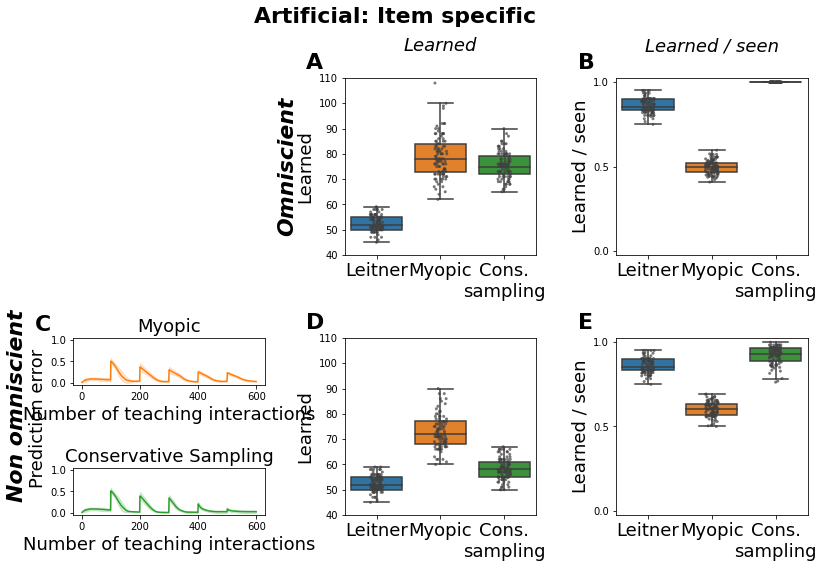

In [17]:
fig = plt.figure(figsize=(12, 8)) # (figsize=(13, 8.5))

# Thanks to the Matplotlib creators that I love
pos = [(4, 3, (2, 5)), (4, 3, (3, 6)),
       (4, 3, 7), (4, 3, 10), (4, 3, (8, 11)), (4, 3, (9, 12))]
axes = [fig.add_subplot(*p) for p in pos]

# Boxplots
boxplot_n_learnt(data=df_omni, ax=axes[0], ylim=ylim, fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt_n_seen(data=df_omni, ax=axes[1], fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt(data=df_not_omni, ax=axes[4], ylim=ylim, fontsize_label=fontsize_label_boxplot)
boxplot_n_learnt_n_seen(data=df_not_omni, ax=axes[5], fontsize_label=fontsize_label_boxplot)

# Prediction error
prediction_error(data=err_threshold, ax=axes[2],
                 title="Myopic",
                 color="C1",
                 fontsize_label=fontsize_label_lineplot)

prediction_error(data=err_forward, ax=axes[3],
                 title="Conservative Sampling",
                 color="C2", 
                 fontsize_label=fontsize_label_lineplot)

# Put title
fig.suptitle("Artificial: Item specific",
             fontweight="bold",
             fontsize=fontsize_title)

# Put subtitles for metric
axes[0].set_title("Learned\n", fontstyle='italic', fontsize=fontsize_subtitle)
axes[1].set_title("Learned / seen\n", fontstyle='italic', fontsize=fontsize_subtitle)

# Add invisible axes
ax_off = fig.add_subplot(1, 1, 1)
ax_off.set_axis_off()

# Add y-label for prediction error plot
ax_off.text(-0.06, 0.07, "Prediction error",
            transform=ax_off.transAxes, size=fontsize_label_lineplot, rotation=90)

# Add subtitles for condition
axes[0].text(-0.3, 0.5, "Omniscient",
             horizontalalignment='center',
             verticalalignment='center',
             transform=axes[0].transAxes, size=fontsize_condition, weight='bold', 
             rotation=90, style="italic")
ax_off.text(-0.09, 0.04, "Non omniscient", transform=ax_off.transAxes, size=fontsize_condition, weight='bold',
            rotation=90, style="italic")

# Put letters
axes[0].text(-0.2, 1.05, ascii_uppercase[0],
             transform=axes[0].transAxes, size=fontsize_letter, weight='bold')
axes[1].text(-0.2, 1.05, ascii_uppercase[1],
             transform=axes[1].transAxes, size=fontsize_letter, weight='bold')
axes[2].text(-0.2, 1.15, ascii_uppercase[2],
             transform=axes[2].transAxes, size=fontsize_letter, weight='bold')
axes[4].text(-0.2, 1.05, ascii_uppercase[3],
             transform=axes[4].transAxes, size=fontsize_letter, weight='bold')
axes[5].text(-0.2, 1.05, ascii_uppercase[4],
             transform=axes[5].transAxes, size=fontsize_letter, weight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])

plt.savefig(os.path.join(fig_folder, f"fig3.png"), dpi=300)
plt.savefig(os.path.join(fig_folder, f"fig3.pdf"))

# Statistics

In [19]:
print("Artificial" + " " + "*"*50)

n_comp = 2
dataset = "n_learnt_leitner"

for condition in "Nspec-omni", "Nspec-Nomni", "spec-omni", "spec-Nomni":

    df = analysis.n_learnt.get_data(dataset_name=dataset,
                                    condition_name=condition)
    print(condition)

    print(f"n item learnt:")
    for teacher in ('threshold', 'forward'):
        x = df[df.teacher == teacher]["n_learnt"]
        y = df[df.teacher == "leitner"]["n_learnt"]
        u, p = stats.mannwhitneyu(
            x=x,
            y=y,
            alternative='two-sided', use_continuity=False)
        print(f"{teacher} vs Leitner")
        p_f = f"$p={p:.3f}$" if p >= 0.001 else "$p<0.001$"
        pc = p*n_comp
        pc_f = "$p_{cor}" + f"={pc:.3f}$" if pc >= 0.001 else "$p_{cor}<0.001$"
        print(f"$u={u}$, {p_f}, {pc_f}, $N={len(x)}" + r"\times 2$")

    print()
    print(f"n learnt / n seen:")
    for teacher in ('threshold', 'forward'):
        x = df[df.teacher == teacher]["ratio_n_learnt_n_seen"]
        y = df[df.teacher == "leitner"]["ratio_n_learnt_n_seen"]
        u, p = stats.mannwhitneyu(
            x=x,
            y=y,
            alternative='two-sided', use_continuity=True)
        print(f"{teacher} vs Leitner")
        p_f = f"$p={p:.3f}$" if p >= 0.001 else "$p<0.001$"
        pc = p*n_comp
        pc_f = "$p_{cor}" + f"={pc:.3f}$" if pc >= 0.001 else "$p_{cor}<0.001$"
        print(f"$u={u}$, {p_f}, {pc_f}, $N={len(x)}" + r"\times 2$")
    print()

Artificial **************************************************
Nspec-omni
n item learnt:
threshold vs Leitner
$u=5650.0$, $p=0.110$, $p_{cor}=0.221$, $N=100\times 2$
forward vs Leitner
$u=8539.0$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$

n learnt / n seen:
threshold vs Leitner
$u=1836.5$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$
forward vs Leitner
$u=8250.0$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$

Nspec-Nomni
n item learnt:
threshold vs Leitner
$u=5976.5$, $p=0.017$, $p_{cor}=0.033$, $N=100\times 2$
forward vs Leitner
$u=7401.5$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$

n learnt / n seen:
threshold vs Leitner
$u=2065.0$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$
forward vs Leitner
$u=4551.5$, $p=0.261$, $p_{cor}=0.521$, $N=100\times 2$

spec-omni
n item learnt:
threshold vs Leitner
$u=10000.0$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$
forward vs Leitner
$u=10000.0$, $p<0.001$, $p_{cor}<0.001$, $N=100\times 2$

n learnt / n seen:
threshold vs Leitner
$u=0.0$, $p<0.0